In [1]:
from fmp_python.fmp import FMP
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os

import statsmodels.api as sm
import matplotlib.pyplot as plt
import scipy.stats as sc

load_dotenv()
FMP_API_KEY = os.getenv("FMP_API_KEY")
fmp = FMP(output_format='pandas',api_key=FMP_API_KEY)

# Week 1 - Return Types, Setup, and Data Foundations


In [2]:
#Access & Download financial data
microsoftData = fmp.get_historical_price("MSFT")

#Overview of Data
microsoftData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1255 non-null   object 
 1   open              1255 non-null   float64
 2   high              1255 non-null   float64
 3   low               1255 non-null   float64
 4   close             1255 non-null   float64
 5   adjClose          1255 non-null   float64
 6   volume            1255 non-null   int64  
 7   unadjustedVolume  1255 non-null   int64  
 8   change            1255 non-null   float64
 9   changePercent     1255 non-null   float64
 10  vwap              1255 non-null   float64
 11  label             1255 non-null   object 
 12  changeOverTime    1255 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 127.6+ KB


### Interesting Notes Include:
- date is an object, appears to be a string in the form: yyyy-mm-dd
- volume and unadjustedVolume are int64 (only integer # of sales)
- label is an object, appears to be a string in the form: month dd, yy
- dataFrame is has latest date at top, I'd like past first
- I also cannot map the 'change' column 

I think the date should be the index (currently none) and it should be a proper datetime

In [3]:
microsoftData['date'] = pd.to_datetime(microsoftData['date'],yearfirst=True) #Fixes the datetime issue
microsoftData = microsoftData.set_index('date') # Sets the new datetime to be the key
microsoftData = microsoftData.sort_index()


In [4]:
#Now if we look at .head() [the first 5 rows] is the key and the top if the oldest record (2020-06-22)
microsoftData.head()

,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
date,,,,,,,,,,,,
2020-06-26,199.73,199.89,194.88,196.33,188.10,54675800,54675800,-3.40,-1.70000,197.7075,"June 26, 20",-0.017000
2020-06-29,195.78,198.53,193.55,198.44,190.12,26701600,26701600,2.66,1.36000,196.5750,"June 29, 20",0.013600
2020-06-30,197.88,204.40,197.74,203.51,194.98,34310300,34310300,5.63,2.85000,200.8825,"June 30, 20",0.028500
2020-07-01,203.14,206.35,201.77,204.70,196.12,32061206,32061206,1.56,0.76794,203.9900,"July 01, 20",0.007679
2020-07-02,205.68,208.02,205.00,206.26,197.61,29315800,29315800,0.58,0.28199,206.2400,"July 02, 20",0.002820


### Simple Plots

- line plots (time series): high, low, close, adjClose

<Axes: xlabel='date'>

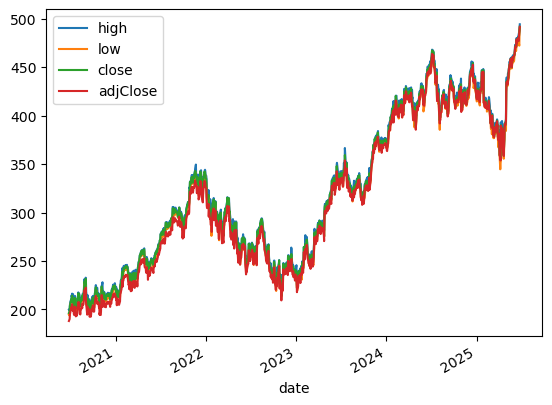

In [5]:
microsoftData[['high','low','close','adjClose']].plot() # quite messy, may be nice to one a year

<Axes: xlabel='date'>

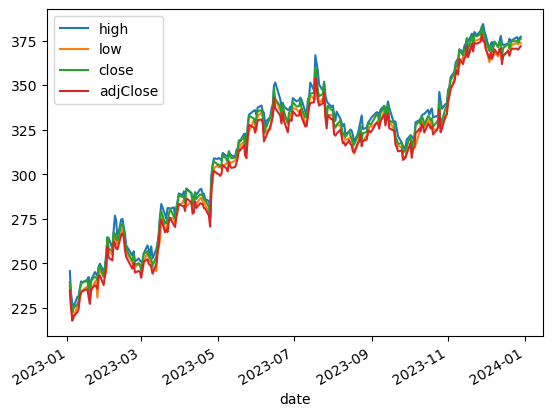

In [6]:
microsoftData_2023 = microsoftData.iloc[microsoftData.index.year == 2023]
microsoftData_2023[['high','low','close','adjClose']].plot()

### Simple Calculations
- simple return (.pct_change)
- log return

In [7]:
microsoftData['simple_return'] = microsoftData['close'].pct_change()
microsoftData['log_return'] = np.log(microsoftData['close'] / microsoftData['close'].shift(1))

<Axes: ylabel='Frequency'>

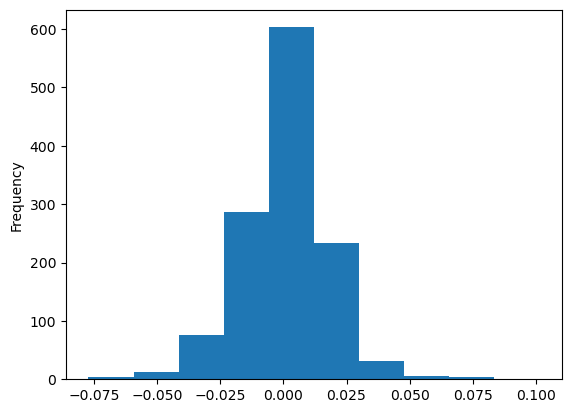

In [8]:
microsoftData['simple_return'].plot(kind='hist')

In [9]:
simple_skew = microsoftData['simple_return'].skew()
simple_kurtosis = microsoftData['simple_return'].kurtosis()

log_skew = microsoftData['log_return'].skew()
log_kurtosis = microsoftData['log_return'].kurtosis()

print(f"The simple returns have a skew={simple_skew} and kurtosis={simple_kurtosis}")
print(f"The log returns have a skew={log_skew} and kurtosis={log_kurtosis}")

The simple returns have a skew=0.12631269650704766 and kurtosis=2.802947854562276
The log returns have a skew=0.0073182664162231605 and kurtosis=2.63478666011884


Interestingly both have a slight positive skew. Initially I beleieved the kurtosis was sub-normal (kurt=3 for the normal), but pandas documents set kurtosis of normal to 0 so this is a higher kurtosis (lepto - fat tailed)

### Confirming the Skew
A qqplot can be used to identify deviations from the normal, because both returns are small, we just plot simple

We see the right side (positive skew) deviates more compared to the left side (netaive skew)

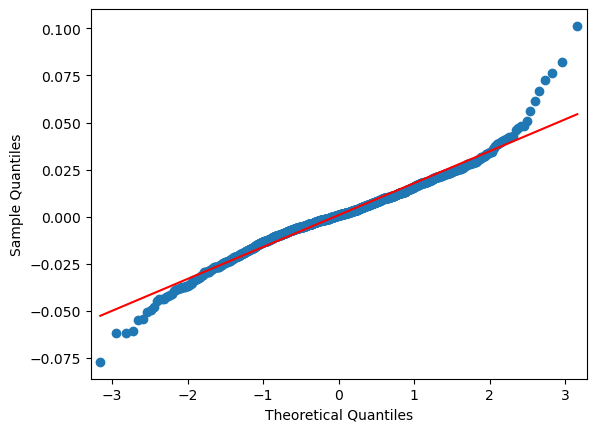

In [11]:
simple_return_array = microsoftData['simple_return'].dropna().to_numpy()
_ = sm.qqplot(simple_return_array,line='s',loc=simple_return_array.mean())


### Cumulative Returns

The log returns are additive whereas the simple return can be found using a cumulative sum

In [12]:
microsoftData['cumulative_return'] = (microsoftData['simple_return'] + 1).cumprod() - 1

In [66]:
# Some modular functions based on the analysis from Week 1

def grab_ticker(api_key_val, ticker):
    fmp = FMP(output_format='pandas',api_key=api_key_val)
    raw_data = fmp.get_historical_price(ticker)
    raw_data['date'] = pd.to_datetime(raw_data['date'],yearfirst=True)
    raw_data = raw_data.set_index('date')
    raw_data = raw_data.sort_index()
    raw_data.index = raw_data.index.tz_localize(None).normalize()
    return raw_data

def single_year_data(df, year):
    return df.iloc[df.index.year == year]

def returns_df(df,ticker):
    basic_returns = pd.DataFrame(
        data={
            f"close_{ticker}":df['close'],
            f"simple_returns_{ticker}":df['close'].pct_change(),
            f"log_returns_{ticker}":np.log(df['close']/df['close'].shift(1))
            } ,index=df.index)
    
    basic_returns[f"cumulative_log_returns_{ticker}"] = basic_returns[f"log_returns_{ticker}"].fillna(0).cumsum()
    basic_returns[f"cumulative_simple_returns_{ticker}"] = (basic_returns[f"simple_returns_{ticker}"].fillna(0) + 1).cumprod() -1
    
    return basic_returns 
    

# Week 2 - Distributions + Cumulative Returns + Intro to Bonds

In the Coursera - Investment Management Course by Geneve University they introduce to methods of valuation in Module 1 (Understanding Financial Markets)

- Discounting (Net Present Value)
- Comparative Analysis (Via Multiples)

### Discounting

If you have a stream of cashflows (np.array of floats) and a discount rate (assumed risk-free rate of growth) that is constant you can discount future cashflow values to the corresponding "present value". 

- Present Value: The amount of money invested at t = 0 to recover the future value under constant growth given by the discount rate

The equation is: 

$$

NPV = \sum_{i=0}^{N}\frac{c_{i}}{(1+r)^{i}}

$$

Where $r$ is the discount rate and $c_{i}$ is the cash flow at timepoint $i$. In this case $c_{0}$ is the initial investment. If $NPV > 0$ the investment is considered favorable, $<0$ is to be avoided.



In [104]:
def npv(discount_rate, cash_flow,interpret):
    flow_size = len(cash_flow)
    discount_multipliers = np.array([1/((1+discount_rate)**i) for i in range(flow_size)])
    pre_sum = discount_multipliers * cash_flow
    npv = np.sum(pre_sum)
    if interpret:
        if npv > 0:
            print(f"The net present value is {npv}, which represents a sound investment.")
        elif npv < 0:
            print(f"The net present value is {npv}, which represents a bad investment.")
        else:
            print("The net present value is 0, the investment is ambiguous under this measure.")
        
    return npv


In [105]:
#A good deal

npv(0.1, np.array([-150,20,50,70,70]),True)

The net present value is 9.907110170070318, which represents a sound investment.


np.float64(9.907110170070318)

In [106]:
#A bad deal

npv(0.1, np.array([100,-90,20,-90,40]),True)

The net present value is -5.587050064886256, which represents a bad investment.


np.float64(-5.587050064886256)

At present, this only account for finite cashflows and disregards things like company debt, long term growth and capital costs. Under the assumption of fixed growth beyond some time horizon ($g$), and a fixed weighted average of capital cost ($r_{c}$), we can determine the *terminal value* ($TV$) assuming the cashflow is infinite and the sum under constant growth converges. (Note: In *A Random Walk Down Wall Street*, this point is highlighted as acount for profits in the future and the here-after). The equation is: 

$$
TV = \frac{1+g}{r_{c}-g}FCF_{N}
$$

Where $FCF_{N}$ is the last known *free cash flow* of the company's financial statements.

In [17]:
def terminal_value(growth_rate,capital_cost,final_flow):
    return ((1+growth_rate)/(capital_cost - growth_rate))*final_flow

We can then discount this using the same multiplier as the final cash to give the *discounted cash flow* ($DCF$):

$$
DCF = \sum_{i=1}^{N}\frac{FCF_{i}}{(1+r_{c})^{i}} + \frac{TV}{(1+r_{c})^{N}},
$$

which is a spin on *NPV*.

In [18]:
def dcf(growth_rate, capital_cost, free_cash_flow):
    flow_size = len(free_cash_flow)
    discount_multiplier = np.array([1/((1+capital_cost)**i) for i in range(1,flow_size+1)])
    t_v = terminal_value(growth_rate, capital_cost, free_cash_flow[-1])
    pre_sum = discount_multiplier*free_cash_flow
    return np.sum(pre_sum) + (t_v/(1+capital_cost)**(flow_size))

Lastly, we can account for exisiting debt $D$ and outstanding stock shares $s$ to derive the *enterprise value* ($EV$) and *fair stock price* ($p_{f}$)

$$
EV = DCF
$$

$$
p_{f} = \frac{EV - D}{s}
$$

In [19]:
def fair_stock(debt,shares_outstanding,growth_rate, capital_cost, free_cash_flow):
    enterprise_value = dcf(growth_rate, capital_cost, free_cash_flow)
    return (enterprise_value - debt) / shares_outstanding

In [20]:
#Load Market Data (SPY - S&P500) and Particular Investment within said Market (GOOGL - Google)
spy_data = grab_ticker(FMP_API_KEY,"SPY")
google_data = grab_ticker(FMP_API_KEY,"GOOGL")

In [21]:
#Calculate Their Returns
google_returns = returns_df(google_data)
spy_returns = returns_df(spy_data)

In [22]:
#Visualize The Distributions
fixed_year = 2024
google_returns = single_year_data(google_returns,fixed_year).rename(columns={"simple_returns":"simple_googl","log_returns":"log_googl"})
spy_returns = single_year_data(spy_returns,fixed_year).rename(columns={"simple_returns":"simple_spy","log_returns":"log_spy"})
google_spy_combined = pd.merge(google_returns,spy_returns,on='date',how='left')

<Axes: ylabel='Frequency'>

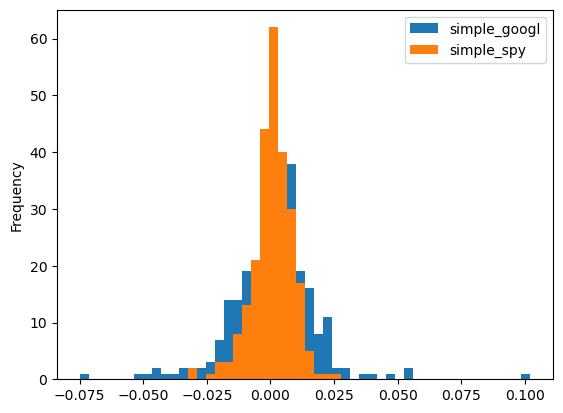

In [23]:
google_spy_combined[['simple_googl','simple_spy']].plot(kind='hist',bins=50)

In [24]:
mean_googl = google_spy_combined['simple_googl'].mean()
std_googl = google_spy_combined['simple_googl'].std()

mean_spy = google_spy_combined['simple_spy'].mean()
std_spy = google_spy_combined['simple_spy'].std()

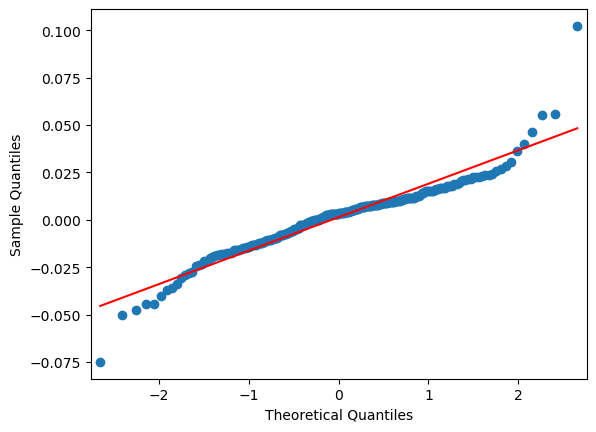

In [25]:
simple_return_google = google_spy_combined['simple_googl'].dropna().to_numpy()
_ = sm.qqplot(simple_return_google,line='s',loc=mean_googl)

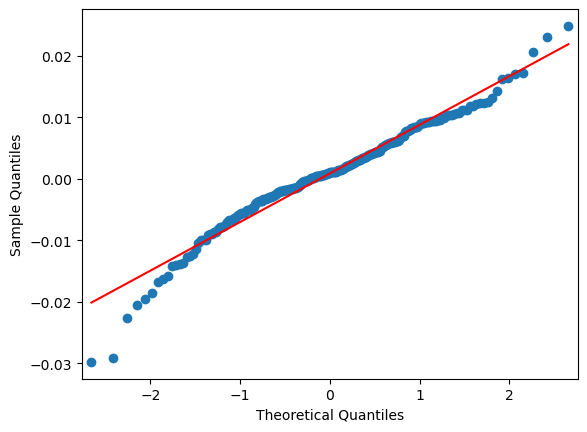

In [26]:
simple_return_spy = google_spy_combined['simple_spy'].dropna().to_numpy()
_ = sm.qqplot(simple_return_spy,line='s',loc=mean_spy)

In [27]:
rate_values_googl = np.arange(-.1,.1,0.001)
rate_values_spy = np.arange(-.05,.05,0.0001)
normal_googl = sc.norm.pdf(rate_values_googl,loc=mean_googl,scale=std_googl)
normal_spy = sc.norm.pdf(rate_values_spy,loc=mean_spy,scale=std_spy)

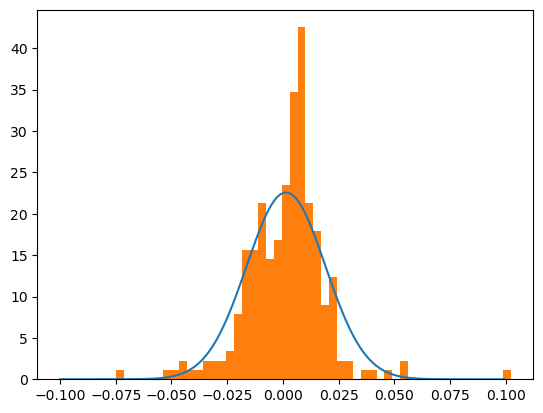

In [28]:
plt.plot(rate_values_googl,normal_googl)
_ = plt.hist(google_spy_combined['simple_googl'],bins=50,density=True)

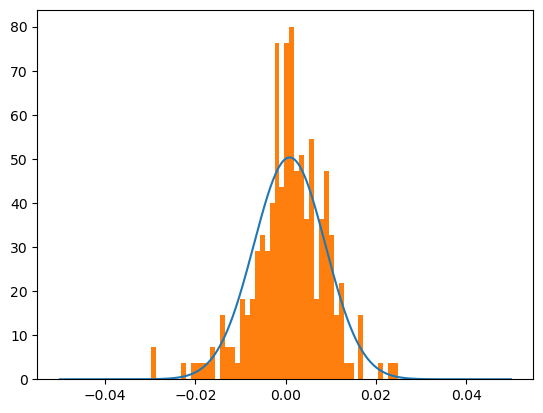

In [29]:
plt.plot(rate_values_spy,normal_spy)
_ = plt.hist(google_spy_combined['simple_spy'],bins=50,density=True)

In [63]:
def format_bond_data(rel_path, term):
    raw_bond_data = pd.read_csv(rel_path)
    raw_bond_data['Date'] = pd.to_datetime(raw_bond_data['Date'])
    raw_bond_data.rename(columns={'Date':'date'},inplace=True)
    raw_bond_data.set_index('date', inplace=True)
    raw_bond_data.sort_index(inplace=True)
    return ((1+raw_bond_data[term]/100)**(1/252) - 1).rename(f"{term}_daily").to_frame()

In [30]:
bond_data = pd.read_csv("C:\\Users\\Austen Couvertier\\OneDrive\\Desktop\\Coding_Projects\\phase_1_quant_foundations\\daily-treasury-rates.csv")

In [31]:
bond_data = bond_data.rename(columns={'Date':'date'})
bond_data['date'] = pd.to_datetime(bond_data['date'],format="%m/%d/%Y") #Fixes the datetime issue
bond_data = bond_data.set_index('date') # Sets the new datetime to be the key
bond_data = bond_data.sort_index()


In [32]:
bond_data['3_Mo_Daily'] = (1 + bond_data['3 Mo']/100)**(1/252) - 1

In [33]:
google_spy_bond_combined = pd.merge(google_spy_combined,bond_data['3_Mo_Daily'],on='date',how='left')

In [34]:
google_spy_bond_combined.ffill(inplace=True)

In [35]:
sharpe_static_googl = (google_spy_bond_combined['simple_googl'].mean() - google_spy_bond_combined['3_Mo_Daily'].mean())/(google_spy_bond_combined['simple_googl'].std())
print(f"For the year {fixed_year}, Google had a daily sharpe of {sharpe_static_googl} and an annual sharpe of {np.sqrt(252)*sharpe_static_googl}")

For the year 2024, Google had a daily sharpe of 0.06572363435346389 and an annual sharpe of 1.0433303505516411


In [36]:
sharpe_static_spy = (google_spy_bond_combined['simple_spy'].mean() - google_spy_bond_combined['3_Mo_Daily'].mean())/(google_spy_bond_combined['simple_spy'].std())
print(f"For the year {fixed_year}, S&P500 had a daily sharpe of {sharpe_static_spy} and an annual sharpe of {np.sqrt(252)*sharpe_static_spy}")

For the year 2024, S&P500 had a daily sharpe of 0.08358638625761149 and an annual sharpe of 1.3268927461693614


# Week 3 - Regression, Volatility, Bond Valuation

In [69]:
def rolling_statistics(stock_tickers,rel_bond_path,term,rolling_window,API_KEY):
    all_stocks = None
    for stock in stock_tickers:
        stock_df = grab_ticker(API_KEY,stock)
        stock_returns_df = returns_df(stock_df,stock)
        if all_stocks is None:
            all_stocks = stock_returns_df
        else:
            all_stocks = all_stocks.merge(stock_returns_df,how='inner',on='date')
    
    bond_data = format_bond_data(rel_bond_path, term)

    all_stocks = bond_data.merge(all_stocks,how='inner',on='date')

    rolling_data = all_stocks.rolling(window=rolling_window)
    all_stocks[f"{rolling_window}_avg_{term}"] = rolling_data[f"{term}_daily"].mean()
    
    for stock in stock_tickers:
        all_stocks[f"{rolling_window}_std_{stock}"] = rolling_data[f"simple_returns_{stock}"].std()
        all_stocks[f"{rolling_window}_avg_{stock}"] = rolling_data[f"simple_returns_{stock}"].mean()
        all_stocks[f"{rolling_window}_excess_{stock}"] = all_stocks[f"{rolling_window}_avg_{stock}"]- all_stocks[f"{rolling_window}_avg_{term}"]
        all_stocks[f"{rolling_window}_sharpe_{stock}"] = (all_stocks[f"{rolling_window}_excess_{stock}"])/all_stocks[f"{rolling_window}_std_{stock}"]
    
    return all_stocks

In [ ]:
thirty_day_rolling = google_spy_bond_combined.rolling(window='30D')

google_spy_bond_combined['30D_Volatility_googl'] = thirty_day_rolling['simple_googl'].std()
google_spy_bond_combined['30D_Volatility_spy'] = thirty_day_rolling['simple_spy'].std()
google_spy_bond_combined['30D_Volatility_bond'] = thirty_day_rolling['3_Mo_Daily'].std()

google_spy_bond_combined['30D_Average_googl'] = thirty_day_rolling['simple_googl'].mean()
google_spy_bond_combined['30D_Average_spy'] = thirty_day_rolling['simple_spy'].mean()
google_spy_bond_combined['30D_Average_bond'] = thirty_day_rolling['3_Mo_Daily'].mean()

google_spy_bond_combined['30D_Sharpe_googl'] = (google_spy_bond_combined['30D_Average_googl'] - google_spy_bond_combined['30D_Average_bond'])/(google_spy_bond_combined['30D_Volatility_googl'])
google_spy_bond_combined['30D_Sharpe_spy'] = (google_spy_bond_combined['30D_Average_spy'] - google_spy_bond_combined['30D_Average_bond'])/(google_spy_bond_combined['30D_Volatility_spy'])

<Axes: xlabel='date'>

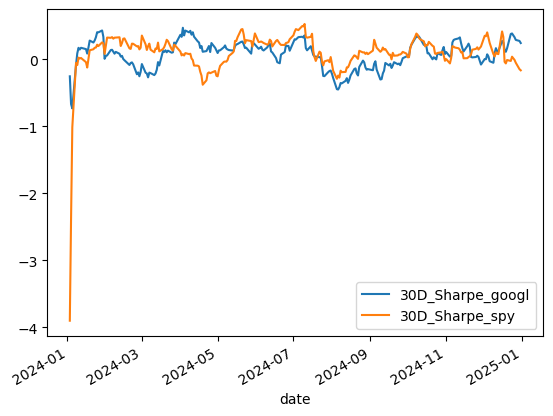

In [39]:
google_spy_bond_combined[['30D_Sharpe_googl','30D_Sharpe_spy']].plot()

<Axes: xlabel='date'>

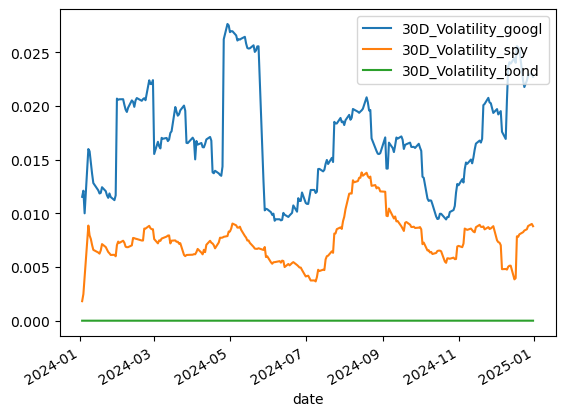

In [40]:
google_spy_bond_combined[['30D_Volatility_googl','30D_Volatility_spy','30D_Volatility_bond']].plot()

In [40]:
google_spy_bond_combined[['simple_googl','simple_spy','3_Mo_Daily','30D_Sharpe_googl','30D_Sharpe_spy']].corr()

,simple_googl,simple_spy,3_Mo_Daily,30D_Sharpe_googl,30D_Sharpe_spy
simple_googl,1.000000,0.551730,-0.032438,0.185647,0.061197
simple_spy,0.551730,1.000000,0.040963,0.048506,0.160322
3_Mo_Daily,-0.032438,0.040963,1.000000,-0.102426,-0.044728
30D_Sharpe_googl,0.185647,0.048506,-0.102426,1.000000,0.356257
30D_Sharpe_spy,0.061197,0.160322,-0.044728,0.356257,1.000000


<Axes: xlabel='market_excess', ylabel='asset_excess'>

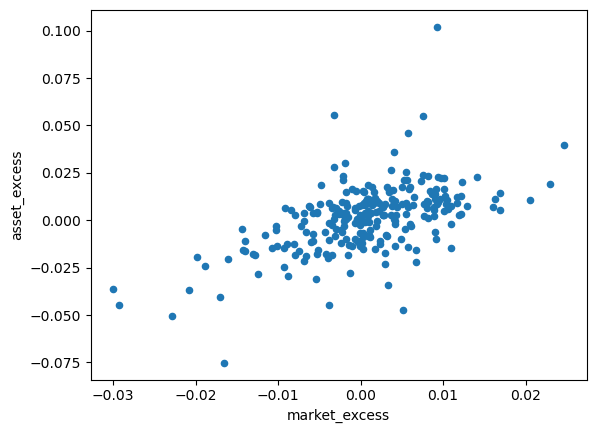

In [41]:
google_spy_bond_combined['market_excess'] = google_spy_combined['simple_spy'] - google_spy_bond_combined['3_Mo_Daily']
google_spy_bond_combined['asset_excess'] = google_spy_combined['simple_googl'] - google_spy_bond_combined['3_Mo_Daily']
google_spy_bond_combined.plot(x='market_excess',y='asset_excess',kind='scatter')

In [46]:
fitted_line =  sc.linregress(google_spy_bond_combined['market_excess'],google_spy_bond_combined['asset_excess'])

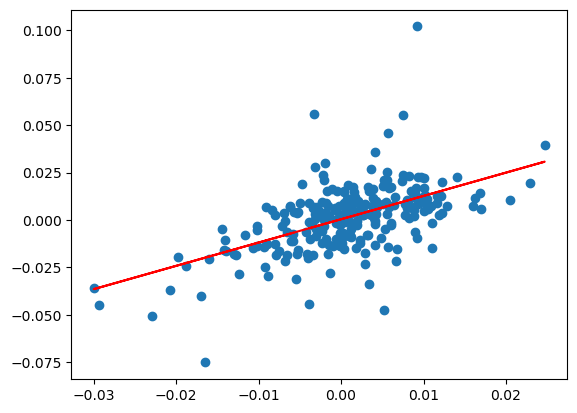

In [49]:
plt.scatter(google_spy_bond_combined['market_excess'],google_spy_bond_combined['asset_excess'])
plt.plot(google_spy_bond_combined['market_excess'],fitted_line.intercept + fitted_line.slope * google_spy_bond_combined['market_excess'],color='red')

In [100]:
intc_nasdaq_data = rolling_statistics(["INTC","NDAQ"],"daily-treasury-rates.csv","3 Mo","50D",FMP_API_KEY)

<Axes: xlabel='50D_excess_NDAQ', ylabel='50D_excess_INTC'>

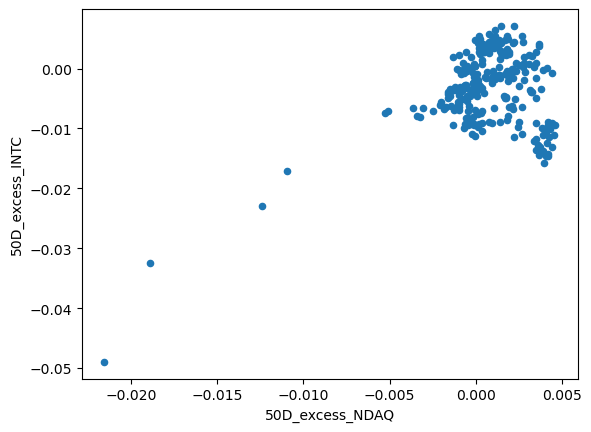

In [103]:
intc_nasdaq_data.plot(y='50D_excess_INTC',x='50D_excess_NDAQ',kind='scatter')

In [141]:
def bond_pv(face_value, coupon, interest_rate, time, periods):
    n = time * periods
    cash_flow = [coupon for _ in range(n)]
    cash_flow[-1] = cash_flow[-1] + face_value
    cash_flow = [0] + cash_flow
    pv = npv(interest_rate/periods, np.array(cash_flow),False)

    return pv

In [142]:
vectorize_bond_pv = np.vectorize(bond_pv)

In [155]:
face_value = 1000
coupon_value = 50
time_years = 5
coupons_per_year = 2
step = 150
rates = np.linspace(0.0,0.5,step)
pvs = vectorize_bond_pv(face_value,coupon_value,rates,time_years,coupons_per_year)

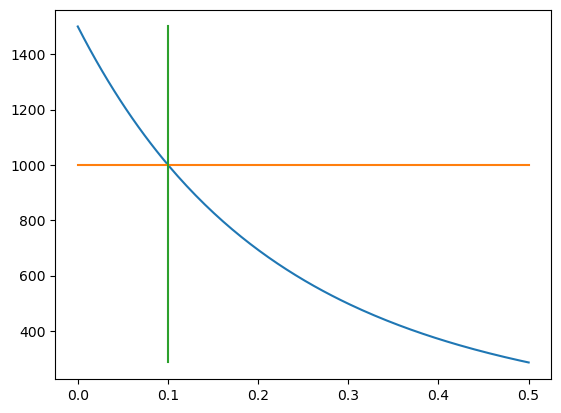

In [156]:
plt.plot(rates,pvs)
plt.plot(rates,[face_value for _ in range(step)])
plt.plot([(coupons_per_year)*(coupon_value)/(face_value) for _ in range(step)],pvs)